# Anomaly Detection in Machine Data with CrateDB and PyCaret


In this Jupyter Notebook, we explore the integration of CrateDB and PyCaret to detect anomalies in machine data, crucial for identifying potential failures or inefficiencies in technological systems. CrateDB's capability for handling large-scale data with ease pairs seamlessly with PyCaret's low-code approach to machine learning, offering a streamlined path to uncovering insights within vast datasets.

Through this tutorial, we'll demonstrate how to harness CrateDB for efficient data retrieval, and leverage PyCaret for its powerful anomaly detection algorithms. This concise guide is designed to equip you with the knowledge to perform anomaly analysis effectively, ensuring the reliability and security of your operations.

This exercise will use the Numenta Anomaly Benchmark (NAB) dataset, which includes real-world and artificial time series data for anomaly detection research. We will choose the dataset about real measured temperature readings from a machine room.

The goal is to detect anomalies in the temperature readings, which could indicate a malfunctioning machine. The dataset simulates machine temperature measurements, and will be loaded into CrateDB upfront.

## Anomaly Detection

Anomaly detection is used to identify outliers or unusual patterns in time series data. This detection technique uses statistical and machine learning algorithms to sift through large data sets over specific time intervals, analyzing patterns, trends, cycles, or seasonality, to spot deviations from the norm. These anomalies could either be an error or indicate another kind of significant event you would like to be alerted about.

Anomaly detection is widely used in multiple fields and industries, including cybersecurity, where it identifies unusual network activity patterns that could signify a potential breach, in finance for spotting fraudulent activities in credit card transactions; and in IoT for detecting malfunctioning sensors and machines. Other use cases include healthcare, for monitoring unusual patient vital signs, and predictive maintenance, where it is used to identify abnormal machine behavior, in order to prevent system failures.

## What is PyCaret?

PyCaret is an open-source, low-code machine learning (ML) library in Python that aims to reduce the cycle time from hypothesis to insights. PyCaret automates much of the ML workflow, including data preprocessing, feature engineering, model selection, hyperparameter tuning, and model deployment, making it accessible for beginners while still being powerful enough for experts.

Integrating PyCaret with CrateDB presents a compelling opportunity for handling large-scale data analytics and ML projects. CrateDB is a distributed SQL database that excels in handling massive amounts of structured and unstructured data in real-time. This integration allows users to leverage CrateDB's efficient data storage and fast query capabilities to manage large datasets, while PyCaret's ML algorithms can be applied directly to this data for predictive analytics, anomaly detection, and other advanced analytics tasks.

By following this notebook you will learn how to extract data from CrateDB for a anomaly analysis in PyCaret.

## Getting started

First, you should install the required dependencies, you can do that by uncommenting and running the next cell. Next, import the ones we will use in this exercise.

[SQLAlchemy]: https://cratedb.com/docs/python/en/latest/sqlalchemy.html
[Pycaret]: https://github.com/pycaret/pycaret

In [1]:
%pip install -r requirements.txt

# Note: If you are running in an environment like Google Colab, please use the absolute path of the requirements:
#%pip install -r https://github.com/crate/cratedb-examples/raw/main/topic/timeseries/requirements.txt

In [1]:
# Data manipulation
import pandas as pd

# CrateDB
import sqlalchemy as sa

# Variables mngmt
import os

# PyCaret for anomaly detection
from pycaret.anomaly import *

# Graph plotting
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


#time transformation
from datetime import datetime

## Import Time Series Data

In this step, we will create the table and populate it with the dataset from [nab-machine-failure.csv]. If you are using CrateDB Cloud, you can use the [URL import] available in the console, otherwise, use the `COPY FROM` statement used below. You can run it in the console in the Admin UI or you can use [Crash], in this case, we are using SQLAlchemy.

[URL import]: https://cratedb.com/docs/cloud/en/latest/reference/overview.html#import-from-url
[nab-machine-failure.csv]: https://github.com/crate/cratedb-datasets/raw/main/timeseries/nab-machine-failure.csv",
[Crash]: https://cratedb.com/docs/crate/crash/en/latest/getting-started.html

In [2]:
# Use this connection string template for CrateDB Cloud Clusters
CONNECTION_STRING = os.environ.get(
     "CRATEDB_CONNECTION_STRING",
     "crate://<USER>:<PASSWORD>@<HOST>",
)

# Use this connection string template for CrateDB running locally
#CONNECTION_STRING = os.environ.get(
#     "CRATEDB_CONNECTION_STRING",
#     "crate://localhost:4200",
# )

engine = sa.create_engine(CONNECTION_STRING, echo=os.environ.get('DEBUG'))

query_create_table = 'CREATE TABLE machine_data ("timestamp" TIMESTAMP, "value" DOUBLE PRECISION)' 
query_copy_from = "COPY machine_data FROM 'https://github.com/crate/cratedb-datasets/raw/main/timeseries/nab-machine-failure.csv';"
with engine.connect() as conn:
    conn.execute(sa.text(query_create_table))
    conn.execute(sa.text(query_copy_from))


## Loading Time Series Data

Once the data is loaded and ready to be used in CrateDB, we can start by accessing it and saving into a DataFrame as follows. 
In this exercise, instead of selecting all data from the `machine_data` table as is, we will use the `DATE_BIN` function to create buckets of 5 minutes and calculate the average for the values whithin the 5 minutes. That is because the models we are going to use require an evenly spaced observation times and, to ensure that, we can use this aggregation function available in CrateDB.

We also convert the timestamp value into a python datetime object.

In [3]:
query = "SELECT DATE_BIN('5 min'::INTERVAL, timestamp, 0) AS timestamp, AVG(value) AS avg_value FROM machine_data GROUP BY timestamp ORDER BY timestamp ASC;"  

with engine.connect() as conn:
    df = pd.read_sql(sql=sa.text(query), con=conn)

df['timestamp'] = df['timestamp'].transform(lambda x: datetime.fromtimestamp(x/1000))

df = df.set_index('timestamp')

df.head()

,avg_value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


## Plotting Time Series Data
Next, plot the data to get a better understanding of the dataset.

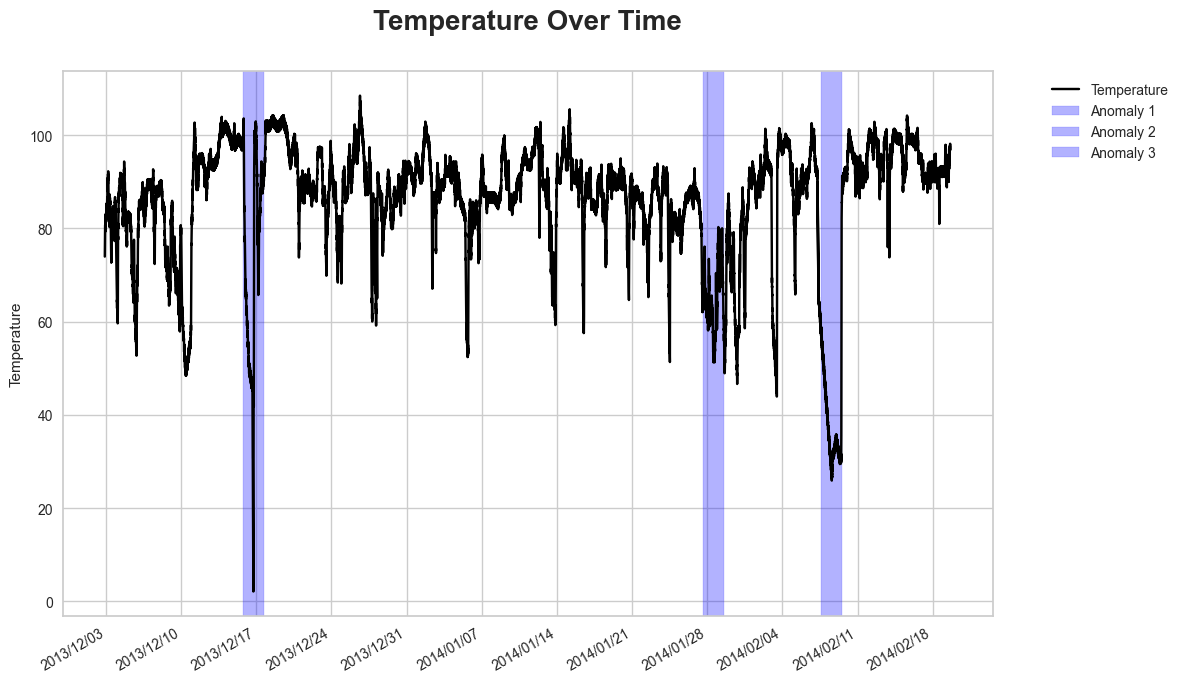

In [4]:
# Known anomalies in the data
anomalies = [
    ["2013-12-15 17:50:00.000000", "2013-12-17 17:00:00.000000"],
    ["2014-01-27 14:20:00.000000", "2014-01-29 13:30:00.000000"],
    ["2014-02-07 14:55:00.000000", "2014-02-09 14:05:00.000000"]
]

plt.figure(figsize=(12,7))
line, = plt.plot(df.index, df['avg_value'], linestyle='solid', color='black', label='Temperature')

# Highlight anomalies
ctr = 0
for timeframe in anomalies:
    ctr += 1
    plt.axvspan(pd.to_datetime(timeframe[0]), pd.to_datetime(timeframe[1]), color='blue', alpha=0.3, label=f'Anomaly {ctr}')

# Formatting x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gcf().autofmt_xdate()  # Rotate & align the x labels for a better view

plt.title('Temperature Over Time', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Temperature')
# Add legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Please note the blue highlighted areas above - these are real, [observed anomalies in the dataset]. You will use them later to evaluate the model. The first anomaly is a planned shutdown of the machine. The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.

You see that there are some nasty spikes in the data, which make anomalies hard to differentiate from ordinary measurements. 

[observed anomalies in the dataset]: https://github.com/numenta/NAB/tree/master/data

## Defining the Anomaly Detection Model

For this step, we are going to use the Pycaret library to identify the anomalies in the dataset. First, start by calling the `setup()` function to initializes the training environment and create the transformation pipeline. Define a `session_id` to ensure the experiment can be reproduced later by using the same seed value. Then, by using the function `models()` you can check all the models available. In this exercise, we are going to use Minimum Covariance Determinant (mcd).

In [5]:
s = setup(df, session_id = 123)
models()

,Description,Value
0,Session id,123
1,Original data shape,"(22683, 1)"
2,Transformed data shape,"(22683, 1)"
3,Numeric features,1
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pycaret.internal.patches.pyod.CBLOFForceToDouble
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


## Running the Unsupervised Anomaly Detection Model
The `create_model()` function trains an unsupervised anomaly detection model. This function assigns anomaly labels to the training data, given a trained model. Below, you may see a sample of the readings that were flagged as 'Anomaly' by the model. You can set the `fraction` parameter to tune the model, in this case we will use `0.025`.

In [6]:
mcd = create_model('mcd',fraction=0.025)
mcd_results = assign_model(mcd)
mcd_results[mcd_results['Anomaly'] == 1].head()

,avg_value,Anomaly,Anomaly_Score
timestamp,,,
2013-12-16 09:20:00,48.102547,1,41.738628
2013-12-16 09:35:00,48.004341,1,41.932248
2013-12-16 10:05:00,47.801910,1,42.332769
2013-12-16 10:20:00,48.207363,1,41.532468
2013-12-16 10:35:00,47.527782,1,42.878183


## Plotting the Results
A better way to see the anomaly readings is to plot all the readings and highlight the anomalies. Below, we use the Plotly library to do that. The red spots correspond to the anomalies flagged by the model.

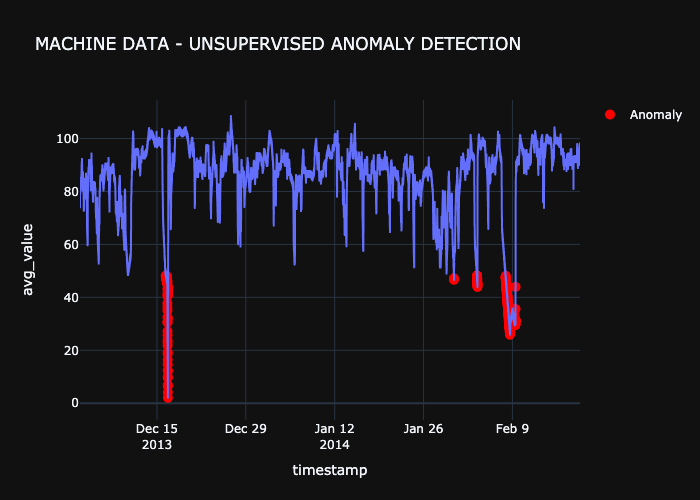

In [7]:
# plot value on y-axis and date on x-axis
pio.renderers.default = 'png'
fig = px.line(mcd_results, x=mcd_results.index, y="avg_value", title='MACHINE DATA - UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')

# create list of outlier_dates
outlier_dates = mcd_results[mcd_results['Anomaly'] == 1].index

# obtain y value of anomalies to plot
y_values = [mcd_results.loc[i]['avg_value'] for i in outlier_dates]

fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers',
                name = 'Anomaly',
                marker=dict(color='red',size=10)))

fig.show()

## Conclusion
Compared to the initial plot with the highlighted outliers, we can see the model managed to identify some of the anomalies well, but also had a couple of false positives. The model could be further tuned to have a better performance and even a different model could be used, but that goes beyond this tutorial's scope.